In [ ]:
# Big Data - Flight Delay Analytics με Apache Spark

import sys
print("Python version:", sys.version)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
# εγκατάσταση pyspark
!pip install pyspark

In [3]:
!apt install openjdk-8-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common librsvg2-common libxcomposite1 libxt-dev
  libxtst6 libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless session-migration x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 

ΘΕΜΑ 1

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, substring, desc
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import time
import csv, io

# δημιουργία spark session
spark = SparkSession.builder.master("local[*]").appName("FlightDelayAnalytics").getOrCreate()

sc = spark.sparkContext # για RDD θέμα 1
print("Spark session started")

# upload file helper (από διάλεξη 3 -> use cases)
def get_csv_path():
    try:
        # Colab / IPython upload
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            return list(uploaded.keys())[0]
    except Exception:
        pass
    # fallback: ask for path
    path = input("Δώσε το path προς το CSV (π.χ. /path/to/bank.csv): ").strip()
    return path

csv_path = get_csv_path() # φόρτωση αρχείου για το θέμα 1

NUM_RUNS = 5 # Αριθμός απαιτούμενων εκτελέσεων

# Λίστα για την καταγραφή των χρόνων (για Θέμα 1 και 3)
rdd_times = {'total': [], 'action': []}

# βοηθητικές συναρτήσεις:
# συνάρτηση για τον υπολογισμό μέσου όρου χρονομέτρήσεων
def calculate_average_time(times_list):

    # Υπολογίζουμε τον μέσο όρο των χρόνων εξαιρώντας τον max και min.
    if len(times_list) < 3:
        return 0.0
    # Ταξινόμηση και αφαίρεση max και min
    sorted_times = sorted(times_list)
    # Μέσος όρος των 3 ενδιάμεσων τιμών
    avg = sum(sorted_times[1:-1]) / 3
    return avg

#συνάρτηση για την εκτύπωση αποτελεσμάτων
def print_time_results(times_dict, api_name):

    # Εμφανίζει τα συνολικά αποτελέσματα χρονομέτρησης.

    print(f"\n ---Αποτελέσματα Χρονομέτρησης ({api_name})---")
    print(f"Όλες οι {NUM_RUNS} εκτελέσεις:")
    print(f"  Συνολικός Χρόνος (Total):  {times_dict['total']}")
    print(f"  Χρόνος Πρώτου Action (Lazy): {times_dict['action']}")

    avg_total = calculate_average_time(times_dict['total'])
    avg_action = calculate_average_time(times_dict['action'])

    print("-------------------------------------------------")
    print(f"Μέσος Όρος 3 Ενδιάμεσων Εκτελέσεων (Total):  {avg_total:.4f} δευτ.")
    print(f"Μέσος Όρος 3 Ενδιάμεσων Εκτελέσεων (Action): {avg_action:.4f} δευτ.")
    print("-------------------------------------------------")

Spark session started


Saving flights_2000.csv to flights_2000.csv


In [5]:
def analyze_rdd():

  # Υλοποιούμε την ανάλυση καθυστέρησης ανά αεροδρόμιο με RDD API

  flights_rdd = sc.textFile(csv_path) # ανάγνωση αρχείου ως RDD
  header = flights_rdd.first()

  # καθαρισμός και parsing

  # αφαίρεση κεφαλίδας και μετατροπή γραμμής σε λίστα
  data_rdd = flights_rdd.filter(lambda row: row != header).map(lambda line: line.split(','))
  # εξαγωγή ζευγαριών (με έλεγχο εγκυρότητας)
  pairs_rdd = data_rdd.filter(lambda fields: fields[10] == "0" and fields[6] != "" ).map(lambda fields: (fields[3], float(fields[6]))) # (ORIGIN_AIRPORT, DEP_DELAY)

  # υπολογισμός μέσης καθυστέρησης με combine by key

  # createCombiner: (sum, count)
  create_combiner = lambda delay: (delay, 1)
  # Προσθήκη νέας τιμής στο άθροισμα/πλήθος
  merge_value = lambda acc, delay: (acc[0] + delay, acc[1] + 1)
  #Συγχώνευση δύο συνδυασμών
  merge_combiners = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])

  sum_count_rdd = pairs_rdd.combineByKey(
       create_combiner,
        merge_value,
        merge_combiners)

  # Υπολογισμός μέσου όρου
  average_delay_rdd = sum_count_rdd.mapValues(
        lambda sum_count: sum_count[0] / sum_count[1])

  # Αλλαγή μορφής σε (delay, airport) για ταξινόμηση κατά τιμή (delay)
  # (το κλειδί γίνεται η μέση καθυστέρηση x[1])
  final_rdd_to_action = average_delay_rdd.map(lambda x: (x[1], x[0])).sortByKey(False)

  # Χρονομέτρηση και σημείο εκκίνησης πριν το action
  start_time = time.time()

  # ACTION: take(10): ενεργοποιεί όλο το DAG (φόρτωση, καθαρισμός, combineByKey, ταξινόμηση)
  top10_rdd = final_rdd_to_action.take(10)

  # Τερματισμός Χρονομέτρησης
  end_time = time.time()
  time_action = end_time - start_time

  # επιστροφή αποτελεσμάτων
  return time_action, top10_rdd

In [6]:
# Εκτέλεση RDD 5 φορές και Χρονομέτρηση

print("ΘΕΜΑ 1: SPARK RDD API - TOP 10 ΑΕΡΟΔΡΟΜΙΑ")

for i in range(NUM_RUNS):
    start_time_total = time.time() # ξεκινάμε το χρονόμετρο για υπολογισμό total time

    time_action, result = analyze_rdd() # παίρνουμε τον χρόνο του action μιας επανάληψης

    end_time_total = time.time() # τερματίζουμε το χρονόμετρο για το total time
    time_total = end_time_total - start_time_total

    # ενημερώνουμε τον πίνακα χρονομέτρων
    rdd_times['total'].append(time_total)
    rdd_times['action'].append(time_action)

    print(f"\n--- RDD Run {i+1} ---")
    print(f"Total Time: {time_total:.4f}s | Action Time: {time_action:.4f}s")

# Εμφάνιση τελικών αποτελεσμάτων (μόνο η τελευταία εκτέλεση)
print("\n RDD Top 10 Αεροδρόμια (Τελευταία Εκτέλεση)")
print("Αεροδρόμιο | Μέση Καθυστέρηση (λεπτά)")
print("---------------------------------")
for delay, airport in result:
    print(f"{airport:10} | {delay:.2f}")

print_time_results(rdd_times, "RDD API")

ΘΕΜΑ 1: SPARK RDD API - TOP 10 ΑΕΡΟΔΡΟΜΙΑ

--- RDD Run 1 ---
Total Time: 6.7540s | Action Time: 1.2808s

--- RDD Run 2 ---
Total Time: 2.9461s | Action Time: 0.7914s

--- RDD Run 3 ---
Total Time: 1.8940s | Action Time: 0.6278s

--- RDD Run 4 ---
Total Time: 2.0273s | Action Time: 0.7612s

--- RDD Run 5 ---
Total Time: 1.9199s | Action Time: 0.6695s

 RDD Top 10 Αεροδρόμια (Τελευταία Εκτέλεση)
Αεροδρόμιο | Μέση Καθυστέρηση (λεπτά)
---------------------------------
DFW        | 11.98
JFK        | 11.20
SEA        | 9.56
ORD        | 9.35
LAS        | 9.11
CLT        | 8.82
MCO        | 8.69
BOS        | 8.63
DEN        | 8.44
MIA        | 8.26

 ---Αποτελέσματα Χρονομέτρησης (RDD API)---
Όλες οι 5 εκτελέσεις:
  Συνολικός Χρόνος (Total):  [6.7539756298065186, 2.9461259841918945, 1.8939969539642334, 2.0272767543792725, 1.9199185371398926]
  Χρόνος Πρώτου Action (Lazy): [1.2808096408843994, 0.7913703918457031, 0.6277713775634766, 0.7611854076385498, 0.6695282459259033]
--------------------

ΘΕΜΑ 2

In [7]:
# Διάβασμα του αρχείου csv
from google.colab import files

uploaded = files.upload()

# Εκτύπωση για επιβεβαίωση
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving flights_2000.csv to flights_2000 (1).csv
User uploaded file "flights_2000 (1).csv" with length 146556 bytes


In [8]:
# Ερώτημα 1

# Ορισμός ονόματος αρχείου
file_name = "flights_2000.csv"

# Διάβασμα αρχείου σε DataFrame
df = spark.read.csv(file_name, header=True, inferSchema=True)

print(f"File '{file_name}' loaded into Spark DataFrame")

File 'flights_2000.csv' loaded into Spark DataFrame


In [9]:
# Ερώτημα 2

print("DataFrame Schema")
df.printSchema()

DataFrame Schema
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



In [10]:
# Ερώτημα 3

# Φιλτράρισμα και καθάρισμα των nulls
cleaned_df = df.filter(col("CANCELLED") == 0).na.drop(subset=["DEP_DELAY"])

# Ομαδοποίηση με βάση την διαδρομή των πτήσεων και aggregation υπολογίζωντας το μέσο όρο της καθυστέρησης
avg_delays_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg(avg("DEP_DELAY").alias("avg_delay"))
# Φθίνουσα ταξινόμηση με βάση το avg_delay
sorted_delays_df = avg_delays_df.orderBy(desc("avg_delay"))
# Αποθήκευση των 10 διαδρομών με τη μεγαλύτερη μέση καθυστέρηση σε DataFrame
top_10_routes_df = sorted_delays_df.limit(10)

print("Top 10 Routes with biggest average delay")
top_10_routes_df.show()

Top 10 Routes with biggest average delay
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+



In [11]:
# Ερώτημα 4

output_folder_name = "out/top_10_routes_csv"

top_10_routes_df.write.mode("overwrite").csv(output_folder_name)

print(f"Results were saved to folder: {output_folder_name}")

Results were saved to folder: out/top_10_routes_csv


In [12]:
# Ερώτημα 5
# εκτελούμε τις 5 επαναλήψεις ώστε να χρονομετρήσουμε αναλυτικά τα βήματα που αποτελλούν το total και το action time

def run_dataframe_analysis():

  # Καταγραφή ακριβούς ώρας - συνολικός χρόνος
  total_start_time = time.time()

  df = spark.read.csv(file_name, header=True, inferSchema=True)

  cleaned_df = df.filter(col("CANCELLED") == 0).na.drop(subset=["DEP_DELAY"])

  avg_delays_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg(avg("DEP_DELAY").alias("avg_delay"))
  sorted_delays_df = avg_delays_df.orderBy(desc("avg_delay"))
  analysis_df = sorted_delays_df.limit(10)

  # Καταγραφή ώρας πριν την εντολή έναρξης - χρόνος action
  action_start_time = time.time()

  analysis_df.show()

  # Σταμάτημα χρονομέτρων
  action_end_time = time.time()
  total_end_time = time.time()

  total_time = total_end_time - total_start_time
  action_time = action_end_time - action_start_time

  return total_time, action_time

# Λίστες για αποθήκευση των χρόνων
total_times = []
action_times = []

print("DataFrame Analysis 5 times")

for i in range(5):
  total_t, action_t = run_dataframe_analysis() #Κλήση συνάρτησης
  print(f"Run {i+1}: Total={total_t:.4f}s, Action={action_t:.4f}s")
  total_times.append(total_t)
  action_times.append(action_t)

print("\n--- Time results (DataFrame) ---")
print(f"Total Time: {total_times}")
print(f"Action Time: {action_times}")

# Υπολογισμός Μέσου Όρου
# Ταξινόμηση λιστών
total_times.sort()
action_times.sort()

# Αφαίρεση min/max χρόνων
avg_total_time = sum(total_times[1:4]) / 3
avg_action_time = sum(action_times[1:4]) / 3

print(f"Average Total Time (3/5 runs): {avg_total_time:.4f}s")
print(f"Average Action Time (3/5 runs): {avg_action_time:.4f}s")

DataFrame Analysis 5 times
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+

Run 1: Total=1.2807s, Action=0.6118s
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|   

ΘΕΜΑ 4

Spark DataFrame (Top 10) transition to Pandas DataFrame
Transition finished
  ORIGIN_AIRPORT DEST_AIRPORT  avg_delay
0            DFW          JFK  23.300000
1            JFK          LAS  22.800000
2            MIA          JFK  20.500000
3            MCO          ORD  19.818182
4            MCO          LAX  19.142857
5            BOS          SEA  18.857143
6            DFW          ATL  18.625000
7            BOS          PHX  18.181818
8            JFK          MIA  18.000000
9            DEN          SFO  17.857143
Chart saved as: out/top_10_routes_chart.png


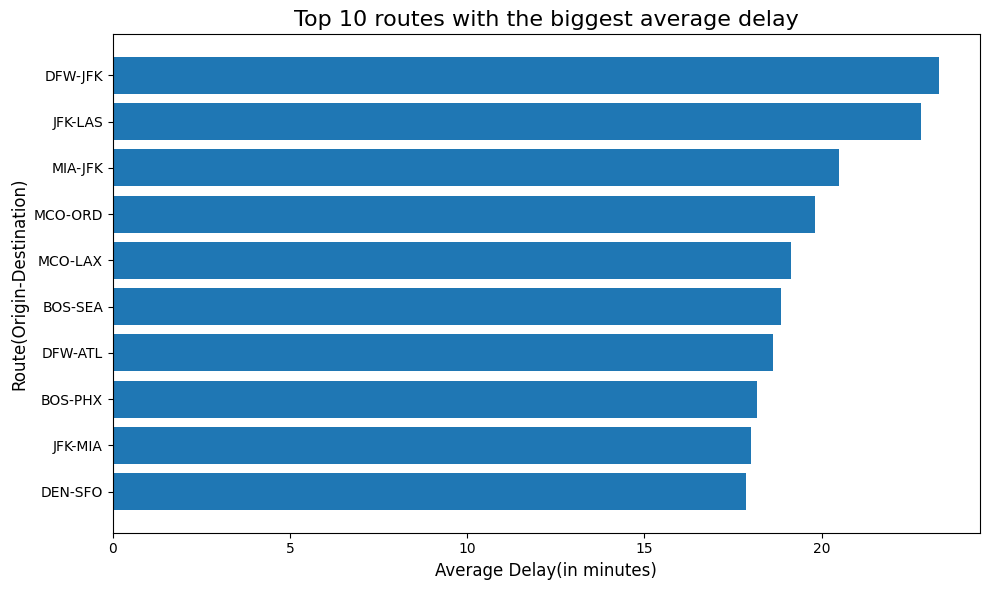

In [13]:
import matplotlib.pyplot as pl

print("Spark DataFrame (Top 10) transition to Pandas DataFrame")
# Μετατροπή από Spark σε Pandas
pandas_df = top_10_routes_df.toPandas()
print("Transition finished")
print(pandas_df)

# Δημιουργία νέας στήλης route
pandas_df['route'] = pandas_df['ORIGIN_AIRPORT'] + '-' + pandas_df['DEST_AIRPORT']

# Αύξουσα ταξινόμηση με βάση avg_delay
pandas_df_sorted = pandas_df.sort_values(by='avg_delay', ascending=True)

# Δημιουργία κενού figure
pl.figure(figsize=(10, 6))

# Σχεδιασμός οριζόντιου ραβδογράμματος
pl.barh(
  pandas_df_sorted['route'], #άξονας Υ
  pandas_df_sorted['avg_delay'] #άξονας Χ
)

# Τίτλοι
pl.title('Top 10 routes with the biggest average delay', fontsize=16)
pl.xlabel('Average Delay(in minutes)', fontsize=12)
pl.ylabel('Route(Origin-Destination)', fontsize=12)

pl.tight_layout()

output_chart_name = "out/top_10_routes_chart.png"
pl.savefig(output_chart_name) # αποθήκευση γραφήματος

print(f"Chart saved as: {output_chart_name}")
pl.show()

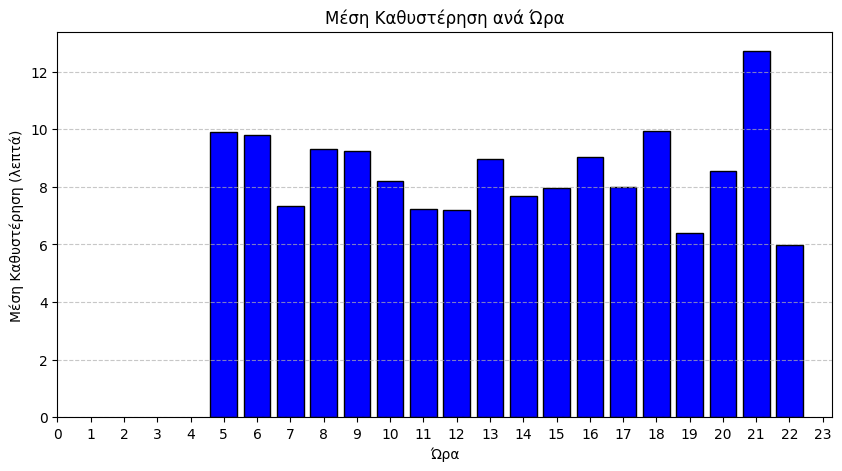

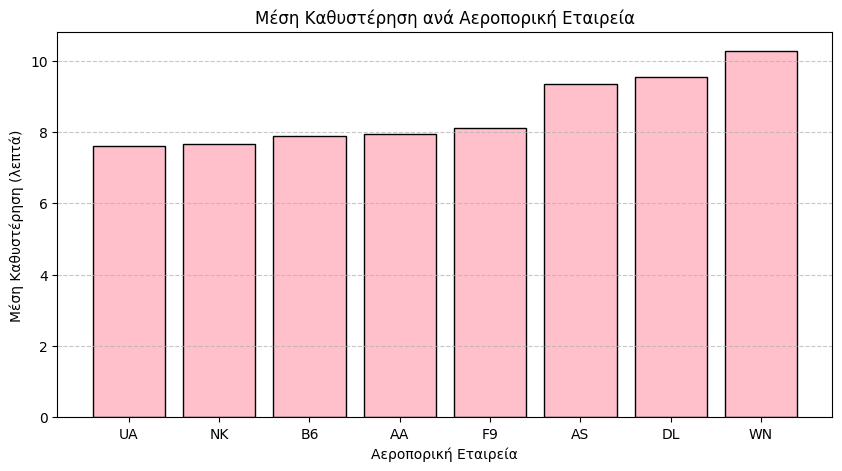

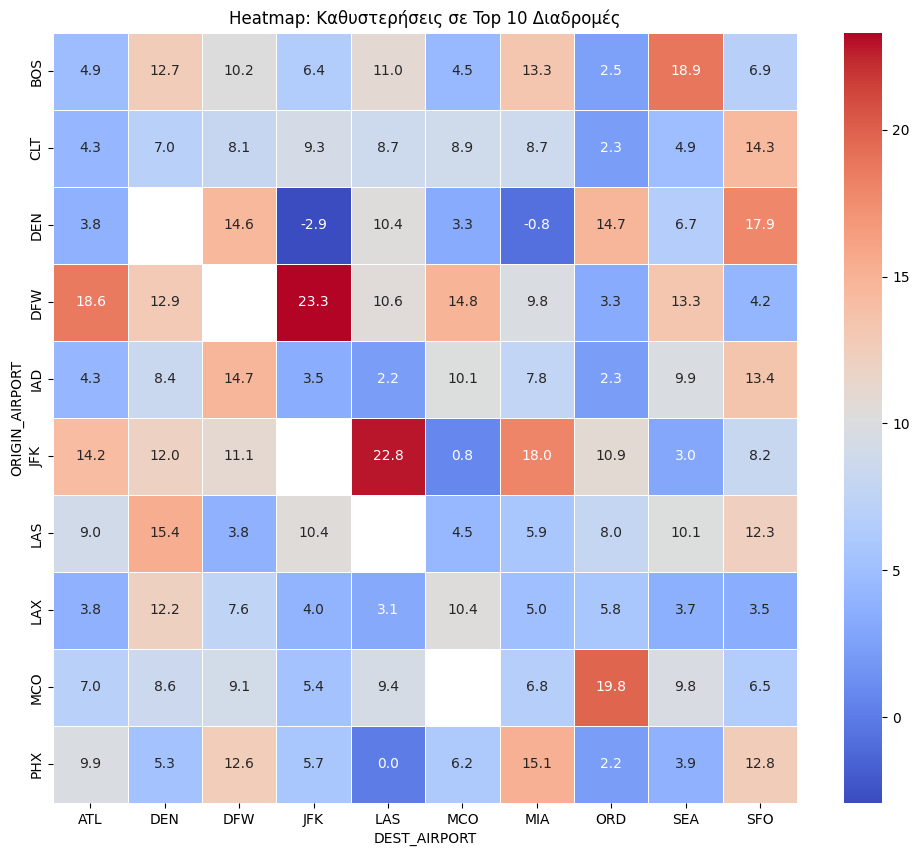

In [14]:
import matplotlib.pyplot as plt # Βιβλιοθήκη για σχεδίαση γραφημάτων
import seaborn as sns  # για σύνθετα γραφήματα (Heatmap)
from pyspark.sql.functions import substring, col, avg, count

# Ερώτημα a

# Δημιουργία στήλης HOUR στο DataFrame μετατρέποντας την στήλη SCED_DEP σε ακέραιο
df_with_hour = cleaned_df.withColumn("HOUR", substring(col("SCHED_DEP"), 12, 2).cast("int"))

# Ομαδοποίηση με βάση την ώρα και υπολογισμός μέσου όρου(όπως Θέμα 2)
hourly_df = df_with_hour.groupBy("HOUR") \
                        .agg(avg("DEP_DELAY").alias("avg_delay")) \
                        .orderBy("HOUR")

# Μετατροπή σε Pandas
hourly_pdf = hourly_df.toPandas()

# Δημιουργία Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(hourly_pdf['HOUR'], hourly_pdf['avg_delay'], color='blue', edgecolor='black')
plt.xlabel("Ώρα")
plt.ylabel("Μέση Καθυστέρηση (λεπτά)")
plt.title("Μέση Καθυστέρηση ανά Ώρα")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("out/plot_a_hourly.png")
plt.show()


# Ερώτημα b

# Ομαδοποίηση με βάση AIRLINE και υπολογισμός μέσης καθυστέρησης
airline_df = cleaned_df.groupBy("AIRLINE") \
                       .agg(avg("DEP_DELAY").alias("avg_delay")) \
                       .orderBy("avg_delay")

# Μετατροπή σε Pandas
airline_pdf = airline_df.toPandas()

# Δημιουργία Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(airline_pdf['AIRLINE'], airline_pdf['avg_delay'], color='pink', edgecolor='black')
plt.xlabel("Αεροπορική Εταιρεία")
plt.ylabel("Μέση Καθυστέρηση (λεπτά)")
plt.title("Μέση Καθυστέρηση ανά Αεροπορική Εταιρεία")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("out/plot_b_airline.png")
plt.show()


# Ερώτημα c

# Υπολογισμός Μέσης Καθυστέρησης για κάθε μοναδική διαδρομή
routes_df = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT") \
                      .agg(avg("DEP_DELAY").alias("avg_delay"))

# Μετατροπή σε Pandas
routes_pdf = routes_df.toPandas()

# Τα 10 πιο συχνά αεροδρόμια αναχώρησης και προορισμού
top_origins = routes_pdf['ORIGIN_AIRPORT'].value_counts().head(10).index
top_dests = routes_pdf['DEST_AIRPORT'].value_counts().head(10).index

# Μόνο οι γραμμές που ανήκουν σε αυτά τα Top 10
filtered_routes = routes_pdf[
    (routes_pdf['ORIGIN_AIRPORT'].isin(top_origins)) &
    (routes_pdf['DEST_AIRPORT'].isin(top_dests))
]

# Μετατροπή της λίστας σε matrix
heatmap_data = filtered_routes.pivot_table(index='ORIGIN_AIRPORT',
                                           columns='DEST_AIRPORT',
                                           values='avg_delay')

# Χρήση Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=.5)
plt.title("Heatmap: Καθυστερήσεις σε Top 10 Διαδρομές")
plt.savefig("out/plot_c_heatmap.png")
plt.show()

In [15]:
!zip -r results.zip out/

  adding: out/ (stored 0%)
  adding: out/plot_b_airline.png (deflated 19%)
  adding: out/plot_a_hourly.png (deflated 18%)
  adding: out/top_10_routes_csv/ (stored 0%)
  adding: out/top_10_routes_csv/.part-00000-b9e7eb5e-5d63-482f-8a36-146c4e8d4c5b-c000.csv.crc (stored 0%)
  adding: out/top_10_routes_csv/_SUCCESS (stored 0%)
  adding: out/top_10_routes_csv/part-00000-b9e7eb5e-5d63-482f-8a36-146c4e8d4c5b-c000.csv (deflated 41%)
  adding: out/top_10_routes_csv/._SUCCESS.crc (stored 0%)
  adding: out/top_10_routes_chart.png (deflated 18%)
  adding: out/plot_c_heatmap.png (deflated 9%)
